In [1]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout

In [ ]:
# train_datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=True, zoom_range=0.2,shear_range=0.2)
# train_generator = train_datagen.flow_from_directory(directory=train_dir,target_size=(256,256),class_mode='categorical',batch_size=32)

# val_datagen = ImageDataGenerator(rescale=1.0/255)
# val_generator = train_datagen.flow_from_directory(directory=val_dir,target_size=(256,256),class_mode='categorical',batch_size=32)

# test_datagen = ImageDataGenerator(rescale=1.0/255)
# test_generator = train_datagen.flow_from_directory(directory=val_dir,target_size=(256,256),class_mode='categorical',batch_size=32)

In [2]:
# generators
train_ds = keras.utils.image_dataset_from_directory(
    directory = 'Face Mask Dataset/Train',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(256,256)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = 'Face Mask Dataset/Validation',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(256,256)
)
   

Found 10000 files belonging to 2 classes.
Found 800 files belonging to 2 classes.


In [3]:
# Normalize
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

In [19]:
model = Sequential()

model.add(Conv2D(32,kernel_size=(3,3), padding='valid', activation='relu',input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),padding='valid',strides=2))

model.add(Conv2D(64,kernel_size=(3,3), padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),padding='valid',strides=2))

model.add(Conv2D(128,kernel_size=(3,3), padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),padding='valid',strides=2))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1,activation='sigmoid'))


In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
batch_normalization_3 (Batch (None, 254, 254, 32)      128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
batch_normalization_4 (Batch (None, 125, 125, 64)      256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 60, 60, 128)      

In [21]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [22]:
history = model.fit(train_ds,epochs=10,validation_data=validation_ds)

Epoch 1/10
313/313 [==============================] - 51s 159ms/step - loss: 1.1158 - accuracy: 0.9522 - val_loss: 2.4480 - val_accuracy: 0.8800
Epoch 2/10
313/313 [==============================] - 49s 157ms/step - loss: 0.3662 - accuracy: 0.9767 - val_loss: 0.2065 - val_accuracy: 0.9675
Epoch 3/10
313/313 [==============================] - 50s 160ms/step - loss: 0.1175 - accuracy: 0.9855 - val_loss: 0.3521 - val_accuracy: 0.9775
Epoch 4/10
313/313 [==============================] - 50s 159ms/step - loss: 0.0962 - accuracy: 0.9889 - val_loss: 5.0297 - val_accuracy: 0.7262
Epoch 5/10
313/313 [==============================] - 50s 158ms/step - loss: 0.0754 - accuracy: 0.9894 - val_loss: 0.4940 - val_accuracy: 0.9325
Epoch 6/10
313/313 [==============================] - 50s 158ms/step - loss: 0.0449 - accuracy: 0.9905 - val_loss: 0.1181 - val_accuracy: 0.9725
Epoch 7/10
313/313 [==============================] - 50s 158ms/step - loss: 0.0290 - accuracy: 0.9926 - val_loss: 0.0598 - val_ac

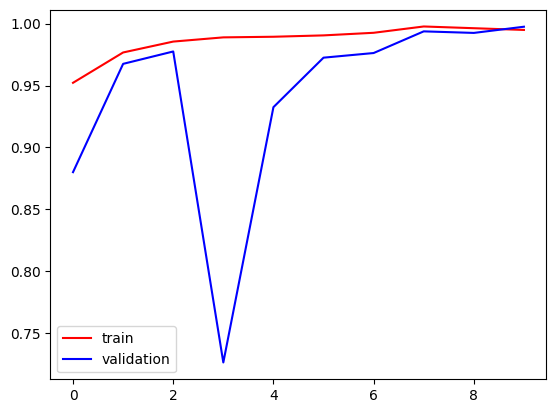

In [23]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

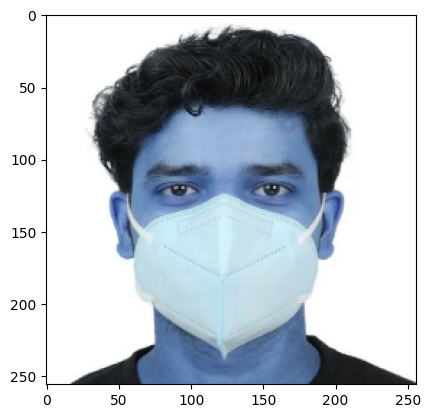

In [24]:
sample_mask_img = cv2.imread('mask1.png')
sample_mask_img = cv2.resize(sample_mask_img,(256,256))
plt.imshow(sample_mask_img)
sample_mask_img = np.reshape(sample_mask_img,[1,256,256,3])
sample_mask_img = sample_mask_img/255.0

In [25]:
model.predict(sample_mask_img)

array([[2.1210547e-18]], dtype=float32)

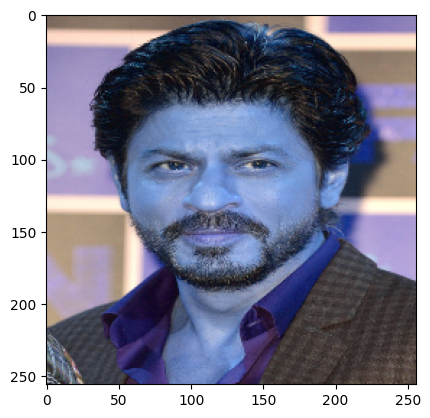

In [26]:
without_mask_img = cv2.imread('srk.jpg')
without_mask_img = cv2.resize(without_mask_img,(256,256))
plt.imshow(without_mask_img)
without_mask_img = np.reshape(without_mask_img,[1,256,256,3])
without_mask_img = without_mask_img/255.0

In [27]:
model.predict(without_mask_img)

array([[2.810308e-16]], dtype=float32)

In [29]:
# Initialize face detector
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# Start video capture
cap = cv2.VideoCapture(0)

while True:
    # Read frame from webcam
    ret, frame = cap.read()
    if not ret:
        break

    # Convert color to gray scale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces in the frame
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    for (x, y, w, h) in faces:
        # Extract face
        face_frame = frame[y:y+h, x:x+w]
        
        # Preprocess the face frame
        face_frame = cv2.resize(face_frame, (256,256))
        face_frame = np.expand_dims(face_frame, axis=0)
        face_frame = face_frame/255.0

        # Predict mask or no mask
        pred = model.predict(face_frame)

        # Determine the class label and color for bounding box
        if pred[0][0]>0.5:
            label = "Mask"
            color = (0, 255, 0)  # Green for mask
        else:
            label = "No Mask"
            color = (0, 0, 255)  # Red for no mask

        # Display bounding box and label
        cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)
        cv2.putText(frame, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

    # Display the frame
    cv2.imshow('Video', frame)

    # Break loop on 'q' key press
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and destroy windows
cap.release()

cv2.destroyAllWindows()